In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from typing import Optional
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Plotting settings
plt.style.use('ggplot')
fig_width = 25  # figure width in cm
inches_per_cm = 0.393701               # Convert cm to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width*inches_per_cm  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]
label_size = 14
tick_size = 12
params = {'backend': 'ps',
          'lines.linewidth': 1.5,
          'axes.labelsize': label_size,
          'axes.titlesize': label_size,
          'font.size': label_size,
          'legend.fontsize': tick_size,
          'xtick.labelsize': tick_size,
          'ytick.labelsize': tick_size,
          'text.usetex': False,
          'figure.figsize': fig_size,
          "font.weight": "bold",
          "axes.labelweight": "bold"}
plt.rcParams.update(params)

In [3]:
class GLD:
    """
    Langevin dynamics approximating SGD on a 1D model
    """
    def __init__(self, lr, q, grad_q, mxx, std_xx, std_xy, w_init, seed):
        """
        lr: learning rate
        q: model
        grad_q: gradient of the model
        mxx: expected value of X^2
        vxx: Var(X^2)
        vxy: Var(XY)
        """
        self.lr = lr
        self.q = q
        self.grad_q = grad_q
        self.mxx = mxx
        self.std_xx = std_xx
        self.std_xy = std_xy
        self.w_init = w_init
        self.w = [self.w_init]
        self.state = np.random.RandomState(seed=seed)


    def update(self, w_old, d1, d2,a=-1,b=1):
        xi_xx = self.state.normal(self.mxx, self.std_xx)
        xi_xy = self.state.normal(0.0, self.std_xy)
        return w_old - self.lr*(xi_xx * self.q(w_old, d1, d2,a,b) - xi_xy) * self.grad_q(w_old, d1, d2,a,b)
    
    def evolve(self, nstep, d1, d2,a=-1,b=1):
        wc = self.w[-1]
        for _ in range(nstep):
            wc = self.update(wc, d1, d2,a,b)
            self.w.append(wc)

class SGD:
    """
    Exact SGD dynamics 
    """
    def __init__(self, lr, q, grad_q, w_init, nsamp, batch_size, seed):
        """
        lr: learning rate
        q: model
        grad_q: gradient of the model
        """
        self.lr = lr
        self.q = q
        self.grad_q = grad_q
        self.nb = batch_size
        self.w = [w_init]
        self.state = np.random.RandomState(seed=seed)
        # uncorrelated X and Y data
        self.x, self.y = self.state.normal(size=(2, nsamp))
        
    def update(self, w_old, d1, d2,a=-1,b=1):
        xb = self.state.choice(self.x, self.nb, replace=False)
        yb = self.state.choice(self.y, self.nb, replace=False)
        
        xi_xx = np.mean(xb*xb)
        xi_xy = np.mean(xb*yb)
        return w_old - self.lr*(xi_xx * self.q(w_old, d1, d2,a,b) - xi_xy) * self.grad_q(w_old, d1, d2,a,b)
    
    def evolve(self, nstep, d1, d2,a=-1,b=1):
        wc = self.w[-1]
        for _ in range(nstep):
            wc = self.update(wc, d1, d2,a,b)
            self.w.append(wc)

def q(w, d1 ,d2, a=-1, b=1):
    return (w - a)**d1 * (w - b)**d2
    
def grad_q(w, d1, d2, a=-1, b=1):
    return (w-a)**(d1-1) * (w - b)**(d2-1) * (d1 * (w - b) + d2*(w - a))



In [15]:
deg = [1,2]
ndeg = len(deg)
d2 = 0
lr = 0.01
mxx = 1.
std_xx = 1.
std_xy = 1.
num_trajectories = 100
niterations = 10**5
nsamp = 10**3
batch_size = 20
# 
a=0
b=0.
wmax = 0
wm = 0.3
mean_dist = np.zeros((ndeg, niterations+1))
distrib = np.zeros((ndeg, num_trajectories))
log_dist_traj = np.zeros((ndeg, num_trajectories, niterations+1))
traj = np.zeros((ndeg, num_trajectories, niterations+1))

print(log_dist_traj.shape)
for id, d in enumerate(deg):
    log_dist = 0
    d1 = d
    for i in range(num_trajectories):
        if i % 50 == 0:
            print(f"trajectory {i} over {num_trajectories}")
        seed = i
        w_init = np.random.uniform(-wm,wm)
        L = SGD(lr, q, grad_q, w_init, nsamp, batch_size, seed)
        L.evolve(niterations, d1, d2,a,b)
        traj[id,i,:] = np.array(L.w)
        log_dist_traj[id,i,:] = np.log(np.abs(np.array(L.w)))
        log_dist += np.log(np.abs(np.array(L.w)))/num_trajectories
        distrib[id,i] = np.array(L.w)[-1] # final distribution
    mean_dist[id,:] = log_dist # mean distance

(2, 100, 100001)
trajectory 0 over 100
trajectory 50 over 100
trajectory 0 over 100
trajectory 50 over 100


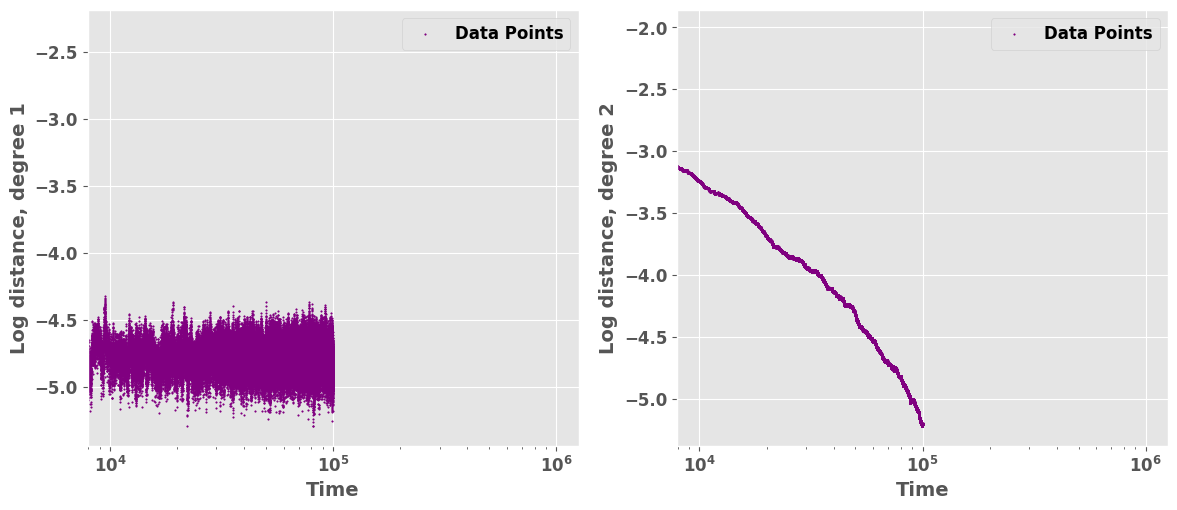

In [16]:
# Compute the coefficient of the line
#from scipy.stats import linregress
%matplotlib inline
time = np.linspace(0, niterations , niterations+1)
# Plotting
plt.figure(figsize=(12, 15))
for i in range(ndeg):
    plt.subplot(3, 2, i+1)
    y = mean_dist[i,:]
    plt.scatter(time, y, label='Data Points', color='purple', s=1)
    plt.xlabel('Time')
    plt.ylabel(f'Log distance, degree {deg[i]}')
    plt.xscale("log")
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

[3.55798518e-02 1.57749167e-02 1.81290177e-04 5.42962032e-07]
[1.71981263e-03 1.73856448e-03 3.68804252e-05 1.79653036e-07]


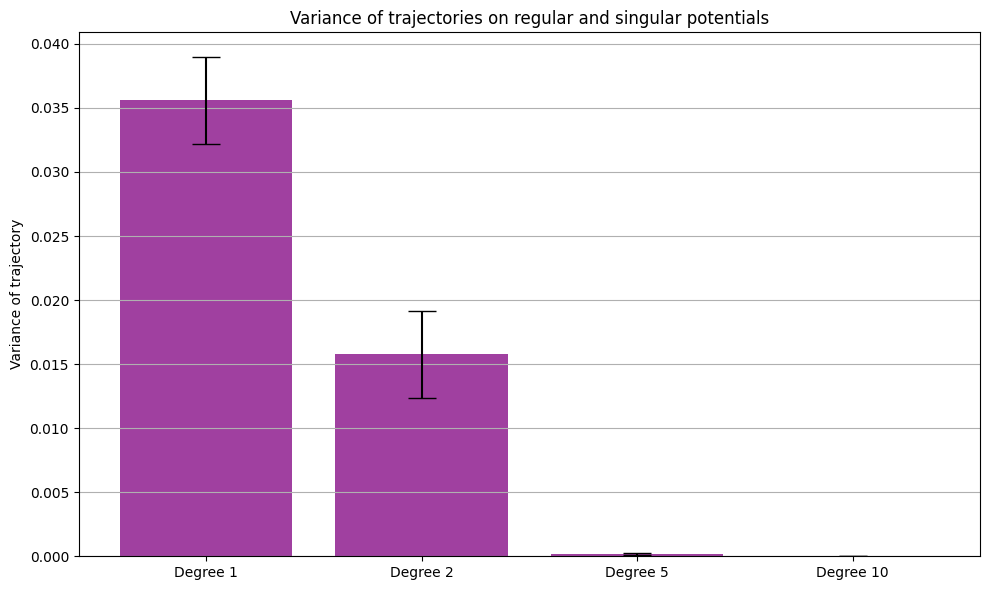

In [ ]:
# Look at the fluctuations of trajectories with different degrees
from scipy.stats import sem 
var_traj = np.std(traj,axis=-1)
mvar_traj = np.mean(var_traj, axis=-1)
sem_var = sem(var_traj,axis=-1)
print(mvar_traj)
print(sem_var)

# Calculate confidence intervals
conf_interval = 1.96 * sem_var

# Bar plot settings
labels = [f"Degree {i}" for i in deg]
x = np.arange(len(labels))

plt.figure(figsize=(10, 6))
plt.bar(x, mvar_traj, yerr=conf_interval, align='center', alpha=0.75, color='purple', capsize=10)
plt.xticks(x, labels)
plt.ylabel('Variance of trajectory')
plt.title('Variance of trajectories on regular and singular potentials')
plt.grid(axis='y')

plt.tight_layout()
plt.show()

In [ ]:
# Look at the "stationary" distribution of trajectories

for id, i in enumerate(deg):
    plt.subplot(3,2,i)
    plt.hist(distrib[id, :], bins="auto", density=True)
    plt.xlabel("Weight")
    plt.ylabel("Density")
    plt.xlim((-wm,wm))
    plt.ylim((0,20))

-1.6118262381331374


Text(0, 0.5, 'Potential')

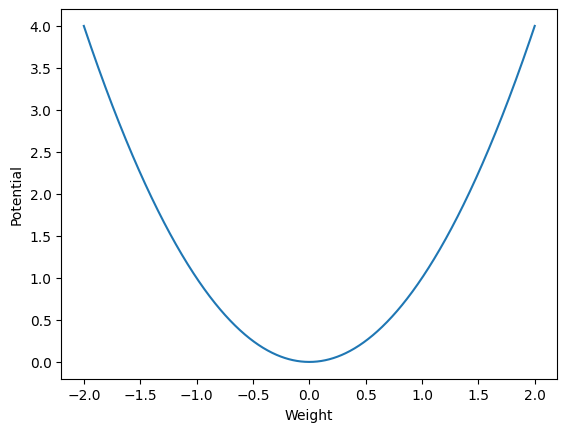

In [ ]:
# Comparing with batch sizes

# Run many trajectories of SGD

d1 = 1
d2 = 0
lr = 0.01
batch_size = 20
nsample = 10**4
mxx = 1.
std_xx = 1.
std_xy = 1.
num_trajectories = 1
niterations = 5000

# Change a and b to play with the potential barrier
a=0
b=0.
wmax = 0
wm = 2
trajectories = []

for i in range(num_trajectories):
    seed = i
    w_init = np.random.uniform(-wm,wm)
    L = SGD_batch(lr, q, grad_q, w_init, nsample, batch_size, seed)
    L.evolve(niterations, d1, d2,a,b)
    trajectories.append(np.array(L.w).T)

trajectories = np.asarray(trajectories)

# Plot potential

wrange = np.linspace(-wm, wm, 1000)
potential = q(wrange, d1 ,d2, a,b)**2
plt.plot(wrange, potential)
plt.xlabel("Weight")
plt.ylabel("Potential")


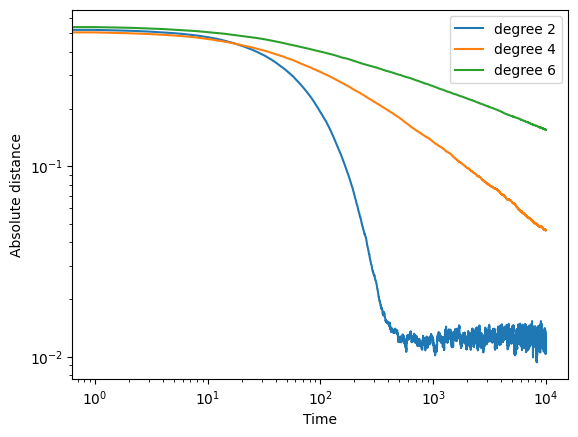

In [ ]:
deg = [1, 2, 3]
ndeg = len(deg)
d2 = 0
lr = 0.01
mxx = 1.
std_xx = 1.
std_xy = 1.
num_trajectories = 100
niterations = 10000
nsample = 10**4
batch_size = 20

# 
a=0
b=0.
wmax = 0
wm = 1
mean_dist = np.zeros((ndeg, niterations+1))
distrib = np.zeros((ndeg, num_trajectories))

for id, d in enumerate(deg):
    dist = 0
    d1 = d
    for i in range(num_trajectories):
        seed = i
        w_init = np.random.uniform(-wm,wm)
        L = SGD_batch(lr, q, grad_q, w_init, nsample, batch_size, seed)
        L.evolve(niterations, d1, d2,a,b)
        dist += np.abs(np.array(L.w))/num_trajectories
        distrib[id,i] = np.array(L.w)[-1]
    mean_dist[id,:] = dist # Pb what is the distribution of trajectories?
        
# average distance over many trajectories
# 
# 
time = np.linspace(0, niterations , niterations+1)
for d in range(ndeg):
    plt.plot(time, mean_dist[d,:], label=f"degree {2*deg[d]}")
    plt.xlabel("Time")
    plt.ylabel("Absolute distance")
    plt.xscale("log")
    plt.yscale("log")
plt.legend()